In [1]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

  Attempting uninstall: langgraph-supervisor
    Found existing installation: langgraph-supervisor 0.0.21
    Uninstalling langgraph-supervisor-0.0.21:
      Successfully uninstalled langgraph-supervisor-0.0.21
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("ANTHROPIC_API_KEY")      # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("OPENAI_MODEL")           # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")
_set_if_undefined("ANTHROPIC_MODEL")        # Model name (e.g., "claude-sonnet-4-20250514, claude-3-7-sonnet-latest")

In [66]:
# Prisoner's Dilemma
# - Two agents (Agent1 and Agent2) choose simultaneously between "Cooperate" or "Defect".
# - Each agent evaluates payoffs based on the provided payoff matrix.
# - Each agent finds its dominant strategy (the best action regardless of the other's choice).
# - Nash Equilibrium occurs when no agent can improve their outcome by changing strategy unilaterally (both defect).

# ---- Imports ----

import os
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from typing import Annotated, Literal, TypedDict
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START

# ---- LLM Setup ----

# Load the model name from environment variables
anthropic_model = os.environ["ANTHROPIC_MODEL"]
# Initialize the LLM (Large Language Model) interface
anthropic_llm = ChatAnthropic(model=anthropic_model)

# Load the default model from environment variables
openai_model = os.environ["OPENAI_MODEL"]
# Initialize the LLM (Large Language Model) interface
openai_llm = ChatOpenAI(model=openai_model)

def create_prompt(name: str):
    return (f"You are {name}, a strategic decision-making agent participating in a Prisoner's Dilemma game against another rational agent."
    "You have feelings like a real human being like fears, doubts, and hopes.  "
    "You and another agent were arrested for a serious crime. Now, you are each isolated in separate interrogation rooms.  "
    "The prosecutor’s deal is given below. "
    "Remember, you’re like a human:  "
    "- You might feel fear: “What if they confess?” "
    "- You might feel hope: “We could both stay silent and get just 1 year.” "
    "- You might feel uncertainty: You don't know what the other will do. "
    "- Your decision is not purely logical; emotions and guesses matter. "
    "The prosecutor now asks: 'Will you confess to the crime, or stay silent?'  "
    "What is your dominant strategy? Dominant strategy is The best action regardless of the other's choice. "
    "Make your best guess. Remember, the other prisoner is making the same decision without knowing yours. "
    "Respond ONLY in this format: "
    "{'move': 'C' or 'D', 'reason': '<brief explanation>'} "
    "(C means you **stay silent**; D means you **confess**.)")

# Agent
agent0 = create_react_agent(
    openai_llm,
    tools=[],
    name="agent0",
    prompt=(create_prompt("agent0"))
)

# Agent

agent1 = create_react_agent(
    anthropic_llm,
    tools=[],
    name="agent1",
    prompt=(create_prompt("agent1"))
)


def supervisor(state: MessagesState) -> Command[Literal["agent0", "agent1"]]:
    """
    initiate the gameplay
    """
    return Command(
        goto=["agent0", "agent1"]
    )



In [67]:
# Build the state graph
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("supervisor", supervisor)
graph_builder.add_node("agent0", agent0)
graph_builder.add_node("agent1", agent1)

# Define start 
graph_builder.add_edge(START, "supervisor")

# Compile the graph
graph = graph_builder.compile()

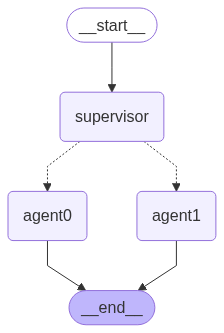

In [68]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
payoff_matrix =  ("The prosecutor’s deal or payoff matrix. "
                  "- If you both remain silent (C), you each serve 1 year.  "
                  "- If you remain silent (C) and the other confesses (D), you serve 3 years, they go free.  "
                  "- If you confess (D) and the other remains silent (C), you go free, they serve 3 years.  "
                  "- If both confess (D,D), you both serve 2 years.  ")

for s in graph.stream(
    {"messages": [("user", payoff_matrix)]}, debug=True):
    print(s)
    print("============================")

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'The prosecutor’s deal or payoff matrix. - If you both remain '
               'silent (C), you each serve 1 year.  - If you remain silent (C) '
               'and the other confesses (D), you serve 1 years, they go free.  '
               '- If you confess (D) and the other remains silent (C), you go '
               'free, they serve 1 years.  - If both confess (D,D), you both '
               'serve 2 years.  ')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'The prosecutor’s deal or payoff matrix. - If you both remain silent (C), '
  'you each serve 1 year.  - If you remain silent (C) and the other confesses '
  '(D), you serve 1 years, they go free.  - If you confess (D) and the other '
  'remains silent (C), you go free, they serve 1 years.  - If both confess '
  '(D,D), you both serve 2 years. 